In [1]:
import numpy as np
import math
import random

# ---------------------------
# Global Seed
# ---------------------------
GLOBAL_SEED = 42
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

# ---------------------------
# Problem Parameters
# ---------------------------
NUM_ROOMS = 10       # Number of hotel rooms
TIME_SLOTS = 24      # Number of time intervals in a day (e.g., 24 hours)
MIN_TEMP = 20.0      # Minimum allowed temperature (°C)
MAX_TEMP = 25.0      # Maximum allowed temperature (°C)
comfort_temp = 22.5  # Desired temperature when a room is occupied

# ---------------------------
# Environment Simulation Functions
# ---------------------------
def generate_outside_temperatures():
    """
    Simulate outside temperatures over the day using a sinusoidal pattern
    with added randomness. Peak temperature occurs around midday.
    
    Returns:
        np.array: Array of length TIME_SLOTS.
    """
    temps = np.empty(TIME_SLOTS)
    for t in range(TIME_SLOTS):
        # Sinusoidal pattern: average 20°C with amplitude 10°C, peak near noon
        temp = 20 + 10 * math.sin(2 * math.pi * (t - 6) / 24)
        # Add random fluctuation
        temp += random.uniform(-2, 2)
        temps[t] = temp
    return temps

def generate_door_open_schedule(prob_open=0.2):
    """
    Generate a schedule indicating whether a room's door is open at each time slot.
    
    Returns:
        np.array: Boolean array of shape (NUM_ROOMS, TIME_SLOTS).
    """
    return (np.random.rand(NUM_ROOMS, TIME_SLOTS) < prob_open)

def generate_orientation_factors():
    """
    Assign an orientation factor to each room based on its facing direction.
    For example, south-facing rooms might have a factor of 1.1 (more sun exposure),
    while north-facing rooms might have a factor of 0.9.
    
    Returns:
        np.array: Array of shape (NUM_ROOMS,) containing the factors.
    """
    orientations = ['north', 'south', 'east', 'west']
    factors = {'north': 0.9, 'south': 1.1, 'east': 1.0, 'west': 1.0}
    room_factors = np.array([factors[random.choice(orientations)] for _ in range(NUM_ROOMS)])
    return room_factors

def generate_occupancy_schedule(occupancy_prob=0.6):
    """
    Simulate an occupancy schedule where each room is occupied at a given time slot 
    with probability `occupancy_prob`.
    
    Returns:
        np.array: Boolean array of shape (NUM_ROOMS, TIME_SLOTS).
    """
    return (np.random.rand(NUM_ROOMS, TIME_SLOTS) < occupancy_prob)

def generate_price_schedule(month):
    """
    Generate a price schedule (EUR per energy unit) for each time slot based on the month.
    
    A simple simulation is used where:
      - Base price is 0.2 EUR/kWh.
      - Hourly variation is modeled with a sine pattern.
      - A month-based multiplier adjusts the cost (e.g., winter months cost more).
    
    Parameters:
        month (int): Month number (1-12).
        
    Returns:
        np.array: Array of length TIME_SLOTS with the price per energy unit.
    """
    base_price = 0.2  # Base EUR per kWh
    # Month factors: assume higher energy cost in winter, lower in summer.
    month_factors = {1: 1.2, 2: 1.2, 3: 1.1, 4: 1.0, 5: 0.9, 6: 0.9,
                     7: 0.8, 8: 0.8, 9: 0.9, 10: 1.0, 11: 1.1, 12: 1.2}
    m_factor = month_factors.get(month, 1.0)
    hours = np.arange(TIME_SLOTS)
    hourly_variation = 0.1 * np.sin(2 * math.pi * hours / TIME_SLOTS)
    price = (base_price + hourly_variation) * m_factor
    return price

# ---------------------------
# Global Precomputed Environment Data
# ---------------------------
outside_temps = generate_outside_temperatures()         # Shape: (TIME_SLOTS,)
door_open_schedule = generate_door_open_schedule(prob_open=0.2)  # Shape: (NUM_ROOMS, TIME_SLOTS), boolean
orientation_factors = generate_orientation_factors()     # Shape: (NUM_ROOMS,)
occupancy_schedule = generate_occupancy_schedule(occupancy_prob=0.6)  # Shape: (NUM_ROOMS, TIME_SLOTS), boolean
current_month = 1  # Example: January
price_schedule = generate_price_schedule(current_month)  # Shape: (TIME_SLOTS,)

# ---------------------------
# Chromosome & Random Solution Generation
# ---------------------------
def generate_random_solution():
    """
    Generates a random solution (chromosome) as a 1D NumPy array.
    
    Each gene is a temperature setpoint for a given room and time slot,
    uniformly sampled from [MIN_TEMP, MAX_TEMP].
    
    Returns:
        np.array: 1D array of length NUM_ROOMS * TIME_SLOTS.
    """
    return np.random.uniform(MIN_TEMP, MAX_TEMP, size=NUM_ROOMS * TIME_SLOTS)

# ---------------------------
# Fitness Function
# ---------------------------
def fitness(chromosome):
    """
    Calculate the fitness of a chromosome, expressed as the total money spent on energy (EUR).
    
    The fitness includes:
      1. **Energy Cost Calculation:**  
         - For each room and time slot, the energy consumption is determined by the difference
           between the setpoint and the outside temperature.
         - Heating is applied if the setpoint is above the outside temperature; cooling if below.
         - A base energy consumption is added.
         - Energy consumption is then adjusted using room orientation factors and door-opening events.
         - Finally, each hour's energy consumption is multiplied by a simulated hourly energy price.
         
      2. **Penalties:**  
         - **Temperature Range Violations:** A penalty of 1000 EUR per degree is added if any setpoint 
           falls outside the allowed range \([MIN\_TEMP, MAX\_TEMP]\).
         - **Occupancy Comfort:** When a room is occupied, a penalty of 50 EUR per degree deviation from the 
           desired comfort temperature is applied.
           
    The function is fully vectorized for efficiency.
    
    Parameters:
        chromosome (np.array): 1D array of length NUM_ROOMS * TIME_SLOTS.
        
    Returns:
        float: Total cost in EUR (lower is better).
    """
    # Reshape chromosome into 2D array (rooms x time slots)
    setpoints = chromosome.reshape((NUM_ROOMS, TIME_SLOTS))
    
    # --- Penalties ---
    # Temperature range violation penalty
    lower_violation = np.maximum(0, MIN_TEMP - setpoints)
    upper_violation = np.maximum(0, setpoints - MAX_TEMP)
    penalty_range = 1000 * (np.sum(lower_violation) + np.sum(upper_violation))
    
    # Occupancy comfort penalty (only apply where room is occupied)
    comfort_penalty = 50 * np.sum(np.abs(setpoints - comfort_temp) * occupancy_schedule)
    
    # --- Energy Consumption Calculation ---
    # Compute the difference between setpoint and outside temperature (broadcasting the outside_temps array)
    delta = setpoints - outside_temps  # Shape: (NUM_ROOMS, TIME_SLOTS)
    
    # Calculate energy consumption:
    #   - For heating (delta > 0): energy = delta * 1.5
    #   - For cooling (delta <= 0): energy = (-delta) * 1.2
    energy_consumption = np.where(delta > 0, delta * 1.5, -delta * 1.2)
    # Add a fixed base consumption per room per time slot
    energy_consumption += 0.5
    
    # Adjust consumption for room orientation (broadcast orientation factors)
    energy_consumption *= orientation_factors[:, np.newaxis]
    
    # Adjust for door opening events: multiply by 1.1 if door is open
    door_factor = np.where(door_open_schedule, 1.1, 1.0)
    energy_consumption *= door_factor
    
    # --- Cost Calculation ---
    # Multiply the energy consumption by the hourly price for each time slot (price_schedule broadcasts)
    cost_matrix = energy_consumption * price_schedule
    total_energy_cost = np.sum(cost_matrix)
    
    # Total fitness = energy cost + penalties
    total_cost = total_energy_cost + penalty_range + comfort_penalty
    return total_cost

# ---------------------------
# Example Usage
# ---------------------------
if __name__ == "__main__":
    # Generate a random solution (chromosome) as a 1D array.
    solution = generate_random_solution()
    
    # Evaluate its fitness (total energy cost in EUR)
    cost = fitness(solution)
    print("Fitness (Total Energy Cost in EUR) of a random solution:", cost)
    # Use the same initial solution for consistency
    init_solution = generate_random_solution()


Fitness (Total Energy Cost in EUR) of a random solution: 9256.071614675717


# Genetic Algorithm

In [2]:
import random
import numpy as np

def genetic_algorithm(
        population_size=100,
        num_generations=1000,
        selection_method='tournament',   # Options: 'tournament', 'roulette', 'rank', 'sus', 'truncation'
        selection_params={'tournament_size': 3},
        crossover_method='uniform',      # Options: 'one_point', 'two_point', 'uniform'
        crossover_params=None,
        mutation_method='gaussian',        # Options: 'gaussian', 'bit_flip'
        mutation_params={'mutation_rate': 0.1, 'sigma': 0.1},
        replacement_method='generational', # Options: 'generational', 'steady_state', 'generational_mixing'
        replacement_params=None,
        elitism_rate=0.05,
        verbose=False):
    """
    Genetic Algorithm (GA) Function.

    -----------------------
    This function implements a Genetic Algorithm for optimization. It begins with a randomly 
    generated population and evolves it over a number of generations. In each generation, the following steps occur:

      1. Selection:
         - Parents are chosen from the current population based on their fitness.
         - Possible Options (with example parameters):
             * 'tournament': Individuals compete in small groups, and the best one is selected. 
               e.g., selection_params = {'tournament_size': 3}
             * 'roulette': Selection probability is proportional to fitness (higher fitness means higher chance of selection).
               e.g., selection_params = {}
             * 'rank': Individuals are ranked by fitness, and selection probability is based on rank.
               e.g., selection_params = {}
             * 'sus': Stochastic Universal Sampling, ensuring a more even selection distribution.
               e.g., selection_params = {}
             * 'truncation': Only the top fraction of the population is selected for reproduction.
               e.g., selection_params = {'truncation_rate': 0.5}
      
      2. Crossover (Recombination):
         - Selected parents are recombined to produce offspring.
         - Possible Options:
             * 'one_point': A single crossover point is selected, and genes are swapped beyond that point.
             * 'two_point': Two crossover points are selected, and genes between them are swapped.
             * 'uniform': Each gene is inherited randomly from one of the two parents.
      
      3. Mutation:
         - Offspring undergo random modifications to maintain diversity.
         - Possible Options:
             * 'gaussian': Adds random noise from a Gaussian distribution to real-valued genes.
               e.g., mutation_params = {'mutation_rate': 0.1, 'sigma': 0.1}
             * 'bit_flip': Flips bits in a binary representation with a certain probability.
               e.g., mutation_params = {'mutation_rate': 0.01}
      
      4. Replacement (Survivor Selection):
         - The next generation is formed by replacing individuals in the population.
         - Possible Options:
             * 'generational': The entire population is replaced by the offspring, except for elite individuals.
               e.g., replacement_method = 'generational', elitism_rate = 0.05
             * 'steady_state': Only a few individuals are replaced at each step, maintaining population stability.
               e.g., replacement_method = 'steady_state'
             * 'generational_mixing': Offspring and parents are mixed, and the best individuals survive.
               e.g., replacement_method = 'generational_mixing'

    Parameters:
        population_size (int): Number of individuals in the population.
        num_generations (int): Number of generations to evolve.
        selection_method (str): Method for selecting parents.
        selection_params (dict): Parameters for the selection method.
        crossover_method (str): Method for recombining parents.
        crossover_params (dict): Parameters for the crossover operator.
        mutation_method (str): Method for mutating offspring.
        mutation_params (dict): Parameters for the mutation operator.
        replacement_method (str): Strategy for forming the next generation.
        replacement_params (dict): Parameters for the replacement method.
        elitism_rate (float): Fraction of the best individuals to retain (for elitist replacement).
        verbose (bool): If True, display progress using tqdm.

    Returns:
        tuple: A tuple containing:
            - best_solution (list): The best solution found (converted to a list).
            - best_fitness (float): The fitness value of the best solution.

    """
    # Set default parameters if none are provided.
    if selection_params is None:
        if selection_method == 'tournament':
            selection_params = {'tournament_size': 3}
        elif selection_method == 'truncation':
            selection_params = {'truncation_rate': 0.7}
        else:
            selection_params = {}
    if crossover_params is None:
        crossover_params = {}
    if mutation_params is None:
        if mutation_method == 'gaussian':
            mutation_params = {'mutation_rate': 0.5, 'sigma': 0.05}
        elif mutation_method == 'bit_flip':
            mutation_params = {'mutation_rate': 0.01}
        else:
            mutation_params = {}
    if replacement_params is None:
        replacement_params = {}

    # ---------------------------
    # Helper functions: Selection Operators
    # ---------------------------
    def tournament_selection(population, fitnesses, params):
        tournament_size = params.get('tournament_size', 3)
        selected = random.sample(list(zip(population, fitnesses)), tournament_size)
        selected.sort(key=lambda x: x[1])
        return selected[0][0]
    
    def roulette_selection(population, fitnesses, params):
        epsilon = 1e-6
        fitness_inv = [1.0 / (f + epsilon) for f in fitnesses]
        total = sum(fitness_inv)
        probabilities = [f / total for f in fitness_inv]
        index = np.random.choice(len(population), p=probabilities)
        return population[index]
    
    def rank_selection(population, fitnesses, params):
        sorted_indices = np.argsort(fitnesses)
        N = len(population)
        # p(i) = (2*(N - i))/(N*(N+1)) where i = 0 (best) to N-1 (worst)
        probs = np.array([2*(N - i) for i in range(1, N+1)]) / (N*(N+1))
        chosen_index = np.random.choice(N, p=probs)
        return population[sorted_indices[chosen_index]]
    
    def sus_selection(population, fitnesses, params):
        epsilon = 1e-6
        fitness_inv = [1.0 / (f + epsilon) for f in fitnesses]
        total = sum(fitness_inv)
        # For one selection, the pointer distance is total.
        start_point = np.random.uniform(0, total)
        cumulative_sum = 0.0
        for ind, fit_inv in zip(population, fitness_inv):
            cumulative_sum += fit_inv
            if cumulative_sum >= start_point:
                return ind
        return population[-1]
    
    def truncation_selection(population, fitnesses, params):
        truncation_rate = params.get('truncation_rate', 0.7)
        N = len(population)
        num_to_select = max(1, int(N * truncation_rate))
        sorted_indices = np.argsort(fitnesses)
        chosen_index = np.random.randint(0, num_to_select)
        return population[sorted_indices[chosen_index]]
    
    if selection_method == 'tournament':
        selection_operator = tournament_selection
    elif selection_method == 'roulette':
        selection_operator = roulette_selection
    elif selection_method == 'rank':
        selection_operator = rank_selection
    elif selection_method == 'sus':
        selection_operator = sus_selection
    elif selection_method == 'truncation':
        selection_operator = truncation_selection
    else:
        raise ValueError("Unknown selection method: {}".format(selection_method))
    
    # ---------------------------
    # Helper functions: Crossover Operators
    # ---------------------------
    def one_point_crossover(parent1, parent2, params):
        point = np.random.randint(1, len(parent1))
        child1 = np.concatenate([parent1[:point], parent2[point:]])
        child2 = np.concatenate([parent2[:point], parent1[point:]])
        return [child1, child2]
    
    def two_point_crossover(parent1, parent2, params):
        point1 = np.random.randint(1, len(parent1) - 1)
        point2 = np.random.randint(point1 + 1, len(parent1))
        child1 = np.concatenate([parent1[:point1], parent2[point1:point2], parent1[point2:]])
        child2 = np.concatenate([parent2[:point1], parent1[point1:point2], parent2[point2:]])
        return [child1, child2]
    
    def uniform_crossover(parent1, parent2, params):
        mask = np.random.rand(len(parent1)) < 0.5
        child1 = np.where(mask, parent1, parent2)
        child2 = np.where(mask, parent2, parent1)
        return [child1, child2]
    
    if crossover_method == 'one_point':
        crossover_operator = one_point_crossover
    elif crossover_method == 'two_point':
        crossover_operator = two_point_crossover
    elif crossover_method == 'uniform':
        crossover_operator = uniform_crossover
    else:
        raise ValueError("Unknown crossover method: {}".format(crossover_method))
    
    # ---------------------------
    # Helper functions: Mutation Operators
    # ---------------------------
    def gaussian_mutation(individual, params):
        mutation_rate = params.get('mutation_rate', 0.05)
        sigma = params.get('sigma', 0.05)
        mutated = individual.copy()
        for i in range(len(mutated)):
            if np.random.rand() < mutation_rate:
                mutated[i] += np.random.normal(0, sigma)
        mutated = np.clip(mutated, MIN_TEMP, MAX_TEMP)
        return mutated
    
    def bit_flip_mutation(individual, params):
        mutation_rate = params.get('mutation_rate', 0.01)
        mutated = individual.copy()
        for i in range(len(mutated)):
            if np.random.rand() < mutation_rate:
                mutated[i] = 1 - mutated[i]
        return mutated
    
    if mutation_method == 'gaussian':
        mutation_operator = gaussian_mutation
    elif mutation_method == 'bit_flip':
        mutation_operator = bit_flip_mutation
    else:
        raise ValueError("Unknown mutation method: {}".format(mutation_method))
    
    # ---------------------------
    # Helper functions: Replacement Operators
    # ---------------------------
    def generational_replacement(population, offspring, fitnesses):
        elite_count = int(elitism_rate * population_size)
        if elite_count > 0:
            sorted_indices = np.argsort(fitnesses)
            elites = [population[i] for i in sorted_indices[:elite_count]]
            return elites + offspring[elite_count:]
        return offspring
    
    def steady_state_replacement(population, offspring, fitnesses):
        combined = population + offspring
        combined_fitness = [fitness(ind) for ind in combined]
        sorted_indices = np.argsort(combined_fitness)
        return [combined[i] for i in sorted_indices[:population_size]]
    
    def generational_mixing_replacement(population, offspring, fitnesses):
        combined = population + offspring
        combined_fitness = [fitness(ind) for ind in combined]
        sorted_indices = np.argsort(combined_fitness)
        return [combined[i] for i in sorted_indices[:population_size]]
    
    if replacement_method in ['generational', 'elitist']:
        replacement_operator = generational_replacement
    elif replacement_method == 'steady_state':
        replacement_operator = steady_state_replacement
    elif replacement_method == 'generational_mixing':
        replacement_operator = generational_mixing_replacement
    else:
        raise ValueError("Unknown replacement method: {}".format(replacement_method))
    
    # ---------------------------
    # Main Genetic Algorithm Loop
    # ---------------------------
    population = [generate_random_solution() for _ in range(population_size)]
    best_solution = None
    best_fitness = float('inf')
    
    if verbose:
        from tqdm import tqdm
        generation_iter = tqdm(range(num_generations), desc="GA Generations")
    else:
        generation_iter = range(num_generations)
    
    for gen in generation_iter:
        fitnesses = [fitness(ind) for ind in population]
        current_best = min(fitnesses)
        if current_best < best_fitness:
            best_fitness = current_best
            best_solution = population[fitnesses.index(current_best)]
        
        offspring = []
        while len(offspring) < population_size:
            parent1 = selection_operator(population, fitnesses, selection_params)
            parent2 = selection_operator(population, fitnesses, selection_params)
            children = crossover_operator(parent1, parent2, crossover_params)
            mutated_children = [mutation_operator(child, mutation_params) for child in children]
            offspring.extend(mutated_children)
        
        offspring = offspring[:population_size]
        population = replacement_operator(population, offspring, fitnesses)
    
    return best_solution.tolist(), best_fitness

# -----------------------------------------------------------------------------
# Possible Options for GA Operators and Example Parameters (as comments):
#
# Selection Methods:
#   - 'tournament':   e.g., selection_method = 'tournament', selection_params = {'tournament_size': 3}
#   - 'roulette':     e.g., selection_method = 'roulette', selection_params = {}
#   - 'sus':          e.g., selection_method = 'sus', selection_params = {}
#   - 'truncation':   e.g., selection_method = 'truncation', selection_params = {'truncation_rate': 0.5}
#
# Crossover Methods:
#   - 'one_point':    e.g., crossover_method = 'one_point'
#   - 'two_point':    e.g., crossover_method = 'two_point'
#   - 'uniform':      e.g., crossover_method = 'uniform'
#
# Mutation Methods:
#   - 'gaussian':     e.g., mutation_method = 'gaussian', mutation_params = {'mutation_rate': 0.1, 'sigma': 0.1}
#   - 'bit_flip':     e.g., mutation_method = 'bit_flip', mutation_params = {'mutation_rate': 0.01}
#
# Replacement Methods:
#   - 'generational':       e.g., replacement_method = 'generational', elitism_rate = 0.05
#   - 'steady_state':       e.g., replacement_method = 'steady_state'
#   - 'generational_mixing':e.g., replacement_method = 'generational_mixing'
#
# -----------------------------------------------------------------------------

random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

best_sol, best_fit = genetic_algorithm(
    population_size=100,
    num_generations=500,
    selection_method='tournament',
    selection_params={'tournament_size': 3},
    crossover_method='uniform',
    mutation_method='gaussian',
    mutation_params={'mutation_rate': 0.1, 'sigma': 0.1},
    replacement_method='generational',
    elitism_rate=0.05,
    verbose=True
)
print("\nGenetic Algorithm Best Fitness:", best_fit)


GA Generations: 100%|██████████| 500/500 [00:04<00:00, 114.21it/s]


Genetic Algorithm Best Fitness: 778.0961014586253


Varying Population Size: 100%|██████████| 7/7 [00:20<00:00,  2.86s/it]


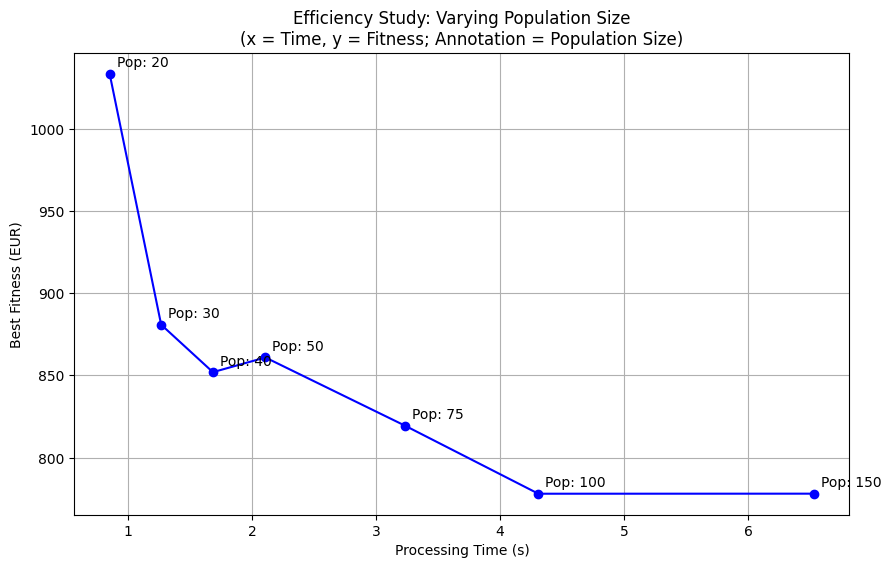

Varying Number of Generations: 100%|██████████| 6/6 [00:55<00:00,  9.33s/it]


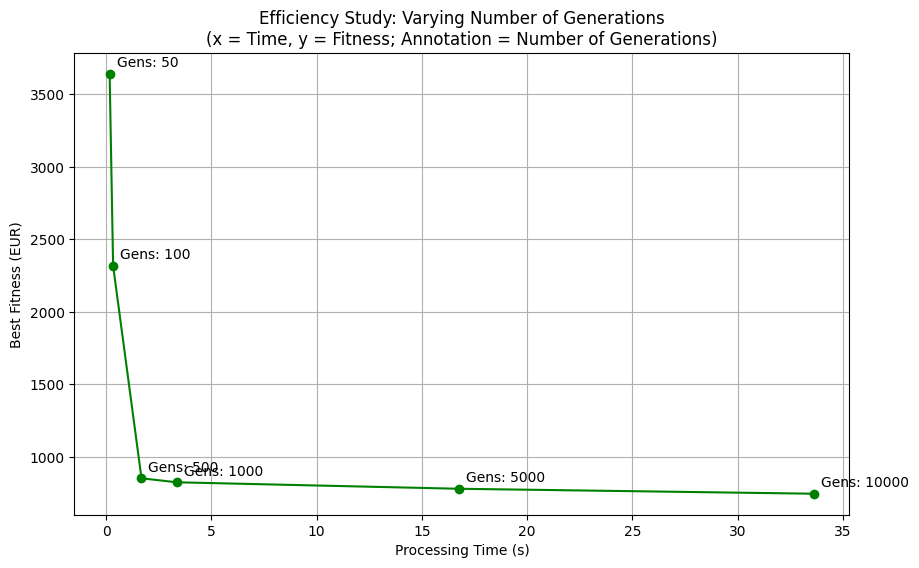

In [3]:
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import numpy as np
import random

# Fixed GA operator parameters:
sel_method = 'tournament'
sel_params = {'tournament_size': 3}
cross_method = 'uniform'
mut_method = 'gaussian'
mut_params = {'mutation_rate': 0.1, 'sigma': 0.1}
rep_method = 'generational'
elitism_rate = 0.05
GLOBAL_SEED = 42  # Global seed for reproducibility

# --- Efficiency Study 1: Varying Population Size ---
population_sizes = [20, 30, 40, 50, 75, 100, 150]
fixed_num_generations = 500  # Fixed number of generations for this study

fitness_vs_pop = []
times_vs_pop = []

for pop in tqdm(population_sizes, desc="Varying Population Size"):
    # Reset the seed before each run
    random.seed(GLOBAL_SEED)
    np.random.seed(GLOBAL_SEED)
    
    start = time.time()
    best_sol, best_fit = genetic_algorithm(
        population_size=pop,
        num_generations=fixed_num_generations,
        selection_method=sel_method,
        selection_params=sel_params,
        crossover_method=cross_method,
        mutation_method=mut_method,
        mutation_params=mut_params,
        replacement_method=rep_method,
        elitism_rate=elitism_rate,
        verbose=False
    )
    elapsed = time.time() - start
    fitness_vs_pop.append(best_fit)
    times_vs_pop.append(elapsed)

# Plot: x = processing time (s), y = best fitness, annotate with population size
plt.figure(figsize=(10, 6))
plt.plot(times_vs_pop, fitness_vs_pop, marker='o', linestyle='-', color='b')
for i, pop in enumerate(population_sizes):
    plt.annotate(f"Pop: {pop}", (times_vs_pop[i], fitness_vs_pop[i]),
                 textcoords="offset points", xytext=(5,5))
plt.xlabel("Processing Time (s)")
plt.ylabel("Best Fitness (EUR)")
plt.title("Efficiency Study: Varying Population Size\n(x = Time, y = Fitness; Annotation = Population Size)")
plt.grid(True)
plt.show()


# --- Efficiency Study 2: Varying Number of Generations ---
num_generations_list = [50, 100, 500, 1000, 5000, 10000]
fixed_population_size = 40  # Fixed population size for this study

fitness_vs_gen = []
times_vs_gen = []

for gens in tqdm(num_generations_list, desc="Varying Number of Generations"):
    # Reset the seed before each run
    random.seed(GLOBAL_SEED)
    np.random.seed(GLOBAL_SEED)
    
    start = time.time()
    best_sol, best_fit = genetic_algorithm(
        population_size=fixed_population_size,
        num_generations=gens,
        selection_method=sel_method,
        selection_params=sel_params,
        crossover_method=cross_method,
        mutation_method=mut_method,
        mutation_params=mut_params,
        replacement_method=rep_method,
        elitism_rate=elitism_rate,
        verbose=False
    )
    elapsed = time.time() - start
    fitness_vs_gen.append(best_fit)
    times_vs_gen.append(elapsed)

# Plot: x = processing time (s), y = best fitness, annotate with number of generations
plt.figure(figsize=(10, 6))
plt.plot(times_vs_gen, fitness_vs_gen, marker='o', linestyle='-', color='g')
for i, gens in enumerate(num_generations_list):
    plt.annotate(f"Gens: {gens}", (times_vs_gen[i], fitness_vs_gen[i]),
                 textcoords="offset points", xytext=(5,5))
plt.xlabel("Processing Time (s)")
plt.ylabel("Best Fitness (EUR)")
plt.title("Efficiency Study: Varying Number of Generations\n(x = Time, y = Fitness; Annotation = Number of Generations)")
plt.grid(True)
plt.show()


Varying Number of Generations: 100%|██████████| 6/6 [00:22<00:00,  3.76s/it]


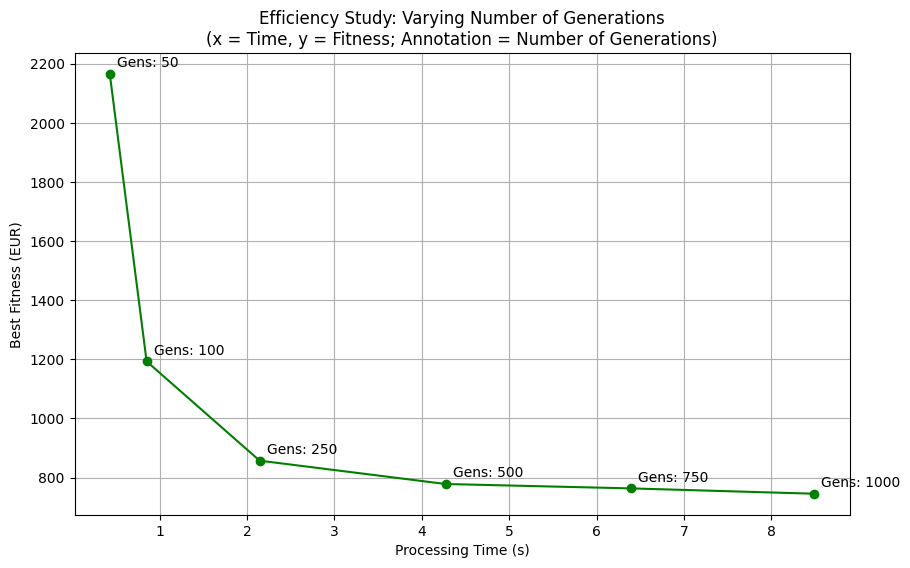

In [4]:
# --- Efficiency Study 2: Varying Number of Generations ---
num_generations_list = [50, 100,250, 500,750, 1000]
fixed_population_size = 100  # Fixed population size for this study

fitness_vs_gen = []
times_vs_gen = []

for gens in tqdm(num_generations_list, desc="Varying Number of Generations"):
    # Reset the seed before each run
    random.seed(GLOBAL_SEED)
    np.random.seed(GLOBAL_SEED)
    
    start = time.time()
    best_sol, best_fit = genetic_algorithm(
        population_size=fixed_population_size,
        num_generations=gens,
        selection_method=sel_method,
        selection_params=sel_params,
        crossover_method=cross_method,
        mutation_method=mut_method,
        mutation_params=mut_params,
        replacement_method=rep_method,
        elitism_rate=elitism_rate,
        verbose=False
    )
    elapsed = time.time() - start
    fitness_vs_gen.append(best_fit)
    times_vs_gen.append(elapsed)

# Plot: x = processing time (s), y = best fitness, annotate with number of generations
plt.figure(figsize=(10, 6))
plt.plot(times_vs_gen, fitness_vs_gen, marker='o', linestyle='-', color='g')
for i, gens in enumerate(num_generations_list):
    plt.annotate(f"Gens: {gens}", (times_vs_gen[i], fitness_vs_gen[i]),
                 textcoords="offset points", xytext=(5,5))
plt.xlabel("Processing Time (s)")
plt.ylabel("Best Fitness (EUR)")
plt.title("Efficiency Study: Varying Number of Generations\n(x = Time, y = Fitness; Annotation = Number of Generations)")
plt.grid(True)
plt.show()

In [5]:
import random
import numpy as np
import time
from tqdm import tqdm
import concurrent.futures

# Assuming GLOBAL_SEED is defined globally:
GLOBAL_SEED = 42

# Define a helper function to run one GA combination.
def run_ga_combination(combo_index, combo, pop_size, num_gens):
    """
    Runs a single GA combination.
    
    Parameters:
        combo_index (int): The index of this combination.
        combo (tuple): A tuple of operator choices and parameter settings.
        pop_size (int): Population size.
        num_gens (int): Number of generations.
    
    Returns:
        dict: A dictionary containing the combination index, operator settings,
              best fitness, and elapsed time.
    """
    # Unpack combination parameters
    sel_method, sel_params, cross_method, mut_method, mut_params, rep_method, rep_params = combo
    
    # Reset the random seed before each run
    random.seed(GLOBAL_SEED)
    np.random.seed(GLOBAL_SEED)
    
    start_time = time.time()
    best_sol, best_fit = genetic_algorithm(
        population_size=pop_size,
        num_generations=num_gens,
        selection_method=sel_method,
        selection_params=sel_params,
        crossover_method=cross_method,
        mutation_method=mut_method,
        mutation_params=mut_params,
        replacement_method=rep_method,
        replacement_params=rep_params,
        elitism_rate=rep_params.get('elitism_rate', 0.0),
        verbose=False
    )
    elapsed = time.time() - start_time
    return {
        'combination': combo_index,
        'sel_method': sel_method,
        'sel_params': sel_params,
        'cross_method': cross_method,
        'mut_method': mut_method,
        'mut_params': mut_params,
        'rep_method': rep_method,
        'rep_params': rep_params,
        'best_fitness': best_fit,
        'time': elapsed
    }

def ga_parameter_study_parallel():
    """
    Perform a comprehensive parameter study for the Genetic Algorithm using 16 processes.
    
    The study explores a grid of operator choices and parameter settings for:
      - Selection: methods and parameters (tournament_size or truncation_rate variations)
      - Crossover: methods ('one_point', 'two_point', 'uniform')
      - Mutation: methods and parameters (gaussian: mutation_rate and sigma; bit_flip: mutation_rate)
      - Replacement: methods and parameters (for generational/elitist/generational_mixing: elitism_rate variations;
                                           steady_state with no extra parameters)
    
    Each combination is run using fixed GA settings (population_size and num_generations) and the best fitness and
    time are recorded.
    
    Returns:
        list of dicts: A list where each dict contains the parameter combination and the corresponding results.
    """
    results = []
    combination_index = 0
    # Fixed GA settings for the study
    pop_size = 100
    num_gens = 500
    
    # Define grids for each operator:
    selection_methods = ['tournament', 'roulette', 'sus', 'truncation']
    selection_params_grid = {}
    for method in selection_methods:
        if method == 'tournament':
            selection_params_grid[method] = [{'tournament_size': ts} for ts in [2, 3, 5]]
        elif method == 'truncation':
            selection_params_grid[method] = [{'truncation_rate': tr} for tr in [0.3, 0.5, 0.7]]
        else:
            selection_params_grid[method] = [{}]
    
    crossover_methods = ['one_point', 'two_point', 'uniform']
    
    mutation_methods = ['gaussian', 'bit_flip']
    mutation_params_grid = {}
    for method in mutation_methods:
        if method == 'gaussian':
            mutation_params_grid[method] = [{'mutation_rate': mr, 'sigma': s} 
                                            for mr in [0.05, 0.1, 0.2] for s in [0.05, 0.1, 0.2]]
        elif method == 'bit_flip':
            mutation_params_grid[method] = [{'mutation_rate': br} for br in [0.005, 0.01, 0.02]]
    
    replacement_methods = ['generational', 'steady_state', 'elitist', 'generational_mixing']
    replacement_params_grid = {}
    for method in replacement_methods:
        if method in ['generational', 'elitist', 'generational_mixing']:
            replacement_params_grid[method] = [{'elitism_rate': er} for er in [0.03, 0.05, 0.1]]
        else:
            replacement_params_grid[method] = [{}]
    
    # Build a list of all combinations
    combinations = []
    for sel_method in selection_methods:
        for sel_params in selection_params_grid[sel_method]:
            for cross_method in crossover_methods:
                for mut_method in mutation_methods:
                    for mut_params in mutation_params_grid[mut_method]:
                        for rep_method in replacement_methods:
                            for rep_params in replacement_params_grid[rep_method]:
                                combinations.append((sel_method, sel_params, cross_method, mut_method, mut_params, rep_method, rep_params))
    
    total_combinations = len(combinations)
    print(f"Total parameter combinations to test: {total_combinations}")
    
    # Use ProcessPoolExecutor with 16 workers for parallel processing.
    with concurrent.futures.ProcessPoolExecutor(max_workers=19) as executor:
        # Prepare futures for each combination
        futures = []
        for idx, combo in enumerate(combinations, start=1):
            futures.append(executor.submit(run_ga_combination, idx, combo, pop_size, num_gens))
        
        # Use tqdm to show progress as futures complete
        for future in tqdm(concurrent.futures.as_completed(futures), total=total_combinations, desc="GA Parameter Study"):
            result = future.result()
            results.append(result)
    
    best_result = min(results, key=lambda r: r['best_fitness'])
    print("\nBest Overall Combination:")
    print(best_result)
    return results

# -----------------------------------------------------------------------------
# Example Usage of the Parallel Parameter Study:
if __name__ == "__main__":
    study_results = ga_parameter_study_parallel()


Total parameter combinations to test: 2880


GA Parameter Study: 100%|██████████| 2880/2880 [17:56<00:00,  2.68it/s]


Best Overall Combination:
{'combination': 2764, 'sel_method': 'truncation', 'sel_params': {'truncation_rate': 0.7}, 'cross_method': 'uniform', 'mut_method': 'gaussian', 'mut_params': {'mutation_rate': 0.05, 'sigma': 0.05}, 'rep_method': 'steady_state', 'rep_params': {}, 'best_fitness': 556.3293547025967, 'time': 8.789758682250977}


In [35]:
# {'combination': 2764, 'sel_method': 'truncation', 'sel_params': {'truncation_rate': 0.7}, 'cross_method': 'uniform', 'mut_method': 'gaussian', 'mut_params': {'mutation_rate': 0.05, 'sigma': 0.05}, 'rep_method': 'steady_state', 'rep_params': {}, 'best_fitness': 556.3293547025967, 'time': 8.789758682250977}

random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

best_solution, best_fitness = genetic_algorithm(
    population_size=100,
    num_generations=1000,             
    selection_method='truncation',   
    selection_params={'truncation_rate': 0.7},           
    crossover_method='uniform', 
    mutation_method='gaussian',      
    mutation_params={'mutation_rate': 0.05, 'sigma': 0.05}, 
    replacement_method='steady_state', 
    replacement_params={},  
    elitism_rate=0.05,      
    verbose=True
)
print("\nGenetic Algorithm Best Fitness:", best_fit)

random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

best_sol, best_fit = genetic_algorithm(
    population_size=100,
    num_generations=1000,
    selection_method='tournament',
    selection_params={'tournament_size': 3},
    crossover_method='uniform',
    mutation_method='gaussian',
    mutation_params={'mutation_rate': 0.1, 'sigma': 0.1},
    replacement_method='generational',
    elitism_rate=0.05,
    verbose=True
)
print("\nGenetic Algorithm Best Fitness:", best_fit)


GA Generations: 100%|██████████| 1000/1000 [00:12<00:00, 80.93it/s]



Genetic Algorithm Best Fitness: 745.2372130221623


GA Generations: 100%|██████████| 1000/1000 [00:08<00:00, 116.14it/s]


Genetic Algorithm Best Fitness: 745.2372130221623


In [34]:
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

best_sol, best_fit = genetic_algorithm(
    # population_size=100,
    # num_generations=500,
    # selection_method='tournament',
    # selection_params={'tournament_size': 3},
    # crossover_method='uniform',
    # mutation_method='gaussian',
    # mutation_params={'mutation_rate': 0.1, 'sigma': 0.1},
    # replacement_method='generational',
    # elitism_rate=0.05,
    verbose=True
)
print("\nGenetic Algorithm Best Fitness:", best_fit)

GA Generations: 100%|██████████| 1000/1000 [00:08<00:00, 116.78it/s]


Genetic Algorithm Best Fitness: 745.2372130221623


# CHC (Cross-generational elitist selection, Heterogeneous recombination, and Cataclysmic mutation)

In [3]:
import random
import numpy as np
from tqdm import tqdm

def chc_algorithm(
        population_size=300,
        max_resets=50,
        initial_threshold=0.7,
        elitism_percentage=0,
        verbose=False):
    """
    CHC Algorithm Function.

    -----------------------
    This function implements a CHC (Cross-generational elitist selection, Heterogeneous recombination,
    and Cataclysmic mutation) algorithm for continuous optimization. Instead of running for a fixed number
    of generations, the algorithm continues until a maximum number of cataclysmic resets is reached.
    
    High-Level Description:
      1. Initialization:
         - A population is generated randomly.
         - The initial recombination threshold is computed based on Euclidean distance 
           (Euclidean distance is chosen because our individuals are represented as real-valued vectors.
            For binary representations, Hamming distance would be more appropriate).
      
      2. Pairing and Recombination:
         - The population is randomly shuffled and paired (using the current population size).
         - For each pair, if the Euclidean distance between the two individuals is at least the current threshold,
           uniform crossover is applied. From the four candidates (the two parents and two offspring),
           the two best individuals (with the lowest fitness) are kept.
      
      3. Cataclysmic Reset:
         - If no pair meets the threshold (indicating that the population has converged), a reset occurs:
             * A fraction (elitism_percentage × population_size) of the best individuals are preserved.
             * The remaining individuals are replaced by new individuals generated by perturbing the best solution.
             * The recombination threshold is halved.
      
      4. Termination:
         - The algorithm stops when the number of resets reaches max_resets.
         - The best solution found is returned.

    Parameters:
        population_size (int): Number of individuals in the population.
        max_resets (int): Maximum number of cataclysmic resets before termination.
        initial_threshold (float or None): Initial distance threshold for recombination.
                                           If None, computed as half of the maximum possible Euclidean distance.
        elitism_percentage (float): Fraction of individuals to preserve during a reset.
        verbose (bool): If True, display a tqdm progress bar for resets.
    
    Returns:
        tuple: (best_solution (list), best_fitness (float))
    """
    # Generate initial population.
    pop = [np.array(generate_random_solution()) for _ in range(population_size)]
    fitnesses = [fitness(ind) for ind in pop]
    best_index = np.argmin(fitnesses)
    best_solution = pop[best_index].copy()
    best_fitness = fitnesses[best_index]
    
    # Compute dimension and maximum possible Euclidean distance.
    dim = len(pop[0])
    max_distance = (MAX_TEMP - MIN_TEMP) * np.sqrt(dim)
    threshold = initial_threshold if initial_threshold is not None else (max_distance / 2)
    
    resets = 0
    pbar = tqdm(total=max_resets, desc="CHC Resets", disable=not verbose)
    
    while resets < max_resets:
        offspring_list = []
        indices = list(range(len(pop)))
        random.shuffle(indices)
        pairs_found = 0
        
        # Pair up individuals using the current population size.
        for i in range(0, len(pop) - 1, 2):
            ind1 = pop[indices[i]]
            ind2 = pop[indices[i + 1]]
            d = np.linalg.norm(ind1 - ind2)
            if d >= threshold:
                pairs_found += 1
                # Uniform crossover:
                mask = np.random.rand(len(ind1)) < 0.5
                child1 = np.where(mask, ind1, ind2)
                child2 = np.where(mask, ind2, ind1)
                # Evaluate fitness for parents and offspring.
                candidates = [(ind1, fitness(ind1)), (ind2, fitness(ind2)),
                              (child1, fitness(child1)), (child2, fitness(child2))]
                candidates.sort(key=lambda x: x[1])
                offspring_list.append(candidates[0][0])
                offspring_list.append(candidates[1][0])
        
        if pairs_found == 0:
            # If no pair met the threshold, perform a cataclysmic reset.
            resets += 1
            pbar.update(1)
            num_elites = max(1, int(elitism_percentage * population_size))
            sorted_indices = np.argsort([fitness(ind) for ind in pop])
            elites = [pop[i].copy() for i in sorted_indices[:num_elites]]
            new_population = elites.copy()
            while len(new_population) < population_size:
                new_ind = best_solution.copy() + np.random.uniform(-1, 1, size=dim)
                new_ind = np.clip(new_ind, MIN_TEMP, MAX_TEMP)
                new_population.append(new_ind)
            pop = new_population
            threshold /= 2  # Halve the threshold.
        else:
            # If the offspring list is smaller than population_size, fill the remainder.
            if len(offspring_list) < population_size:
                extra = population_size - len(offspring_list)
                offspring_list.extend([best_solution.copy() for _ in range(extra)])
            pop = offspring_list
        
        fitnesses = [fitness(ind) for ind in pop]
        current_best_index = np.argmin(fitnesses)
        if fitnesses[current_best_index] < best_fitness:
            best_fitness = fitnesses[current_best_index]
            best_solution = pop[current_best_index].copy()
    
    pbar.close()
    return best_solution.tolist(), best_fitness

random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

best_sol, best_fit = chc_algorithm(
    population_size=50,
    max_resets=25,
    initial_threshold=None,  # Automatically computed if None
    elitism_percentage=0.1,
    verbose=True  # Use tqdm for progress updates.
)
print("\nCHC Algorithm Best Fitness:", best_fit)


CHC Resets: 100%|██████████| 25/25 [00:04<00:00,  5.73it/s]


CHC Algorithm Best Fitness: 666.647867645084


Population Size Study: 100%|██████████| 7/7 [02:02<00:00, 17.57s/it]


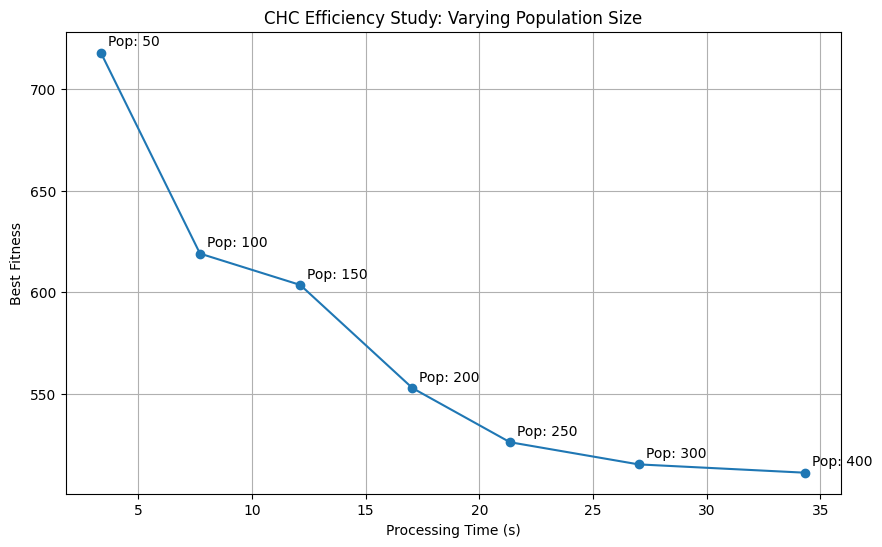

Max Resets Study: 100%|██████████| 6/6 [02:02<00:00, 20.39s/it]


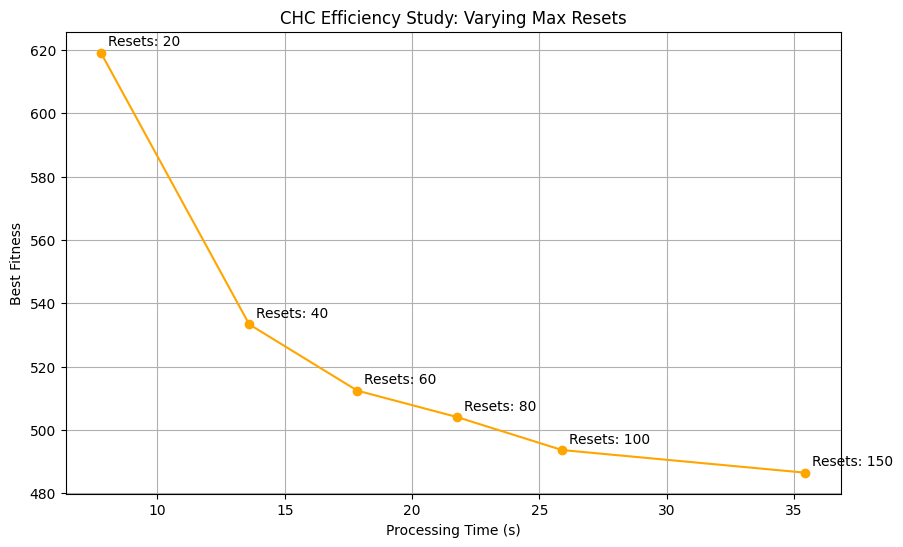

In [5]:
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import random
import numpy as np

# Efficiency Study 1: Vary Population Size (fixed max_resets)
pop_sizes = [50, 100, 150, 200, 250, 300,400]
fixed_max_resets = 20  # fixed for this study

fitness_vs_pop = []
times_vs_pop = []

for pop in tqdm(pop_sizes, desc="Population Size Study"):
    random.seed(GLOBAL_SEED)
    np.random.seed(GLOBAL_SEED)
    start = time.time()
    best_sol, best_fit = chc_algorithm(
        population_size=pop,
        max_resets=fixed_max_resets,
        initial_threshold=None,  # computed automatically
        elitism_percentage=0.1,
        verbose=False
    )
    elapsed = time.time() - start
    fitness_vs_pop.append(best_fit)
    times_vs_pop.append(elapsed)

# Plot: x = time, y = fitness; annotate with population size.
plt.figure(figsize=(10, 6))
plt.plot(times_vs_pop, fitness_vs_pop, marker='o', linestyle='-')
for i, pop in enumerate(pop_sizes):
    plt.annotate(f"Pop: {pop}", (times_vs_pop[i], fitness_vs_pop[i]), textcoords="offset points", xytext=(5,5))
plt.xlabel("Processing Time (s)")
plt.ylabel("Best Fitness")
plt.title("CHC Efficiency Study: Varying Population Size")
plt.grid(True)
plt.show()

# Efficiency Study 2: Vary max_resets (fixed population size)
max_resets_list = [20, 40, 60, 80, 100,150]
fixed_pop_size = 100  # fixed for this study

fitness_vs_resets = []
times_vs_resets = []

for resets in tqdm(max_resets_list, desc="Max Resets Study"):
    random.seed(GLOBAL_SEED)
    np.random.seed(GLOBAL_SEED)
    start = time.time()
    best_sol, best_fit = chc_algorithm(
        population_size=fixed_pop_size,
        max_resets=resets,
        initial_threshold=None,
        elitism_percentage=0.1,
        verbose=False
    )
    elapsed = time.time() - start
    fitness_vs_resets.append(best_fit)
    times_vs_resets.append(elapsed)

# Plot: x = time, y = fitness; annotate with max_resets.
plt.figure(figsize=(10, 6))
plt.plot(times_vs_resets, fitness_vs_resets, marker='o', linestyle='-', color='orange')
for i, r in enumerate(max_resets_list):
    plt.annotate(f"Resets: {r}", (times_vs_resets[i], fitness_vs_resets[i]), textcoords="offset points", xytext=(5,5))
plt.xlabel("Processing Time (s)")
plt.ylabel("Best Fitness")
plt.title("CHC Efficiency Study: Varying Max Resets")
plt.grid(True)
plt.show()

Best Overall Parameters:
  Threshold Fraction: 0.6
  Elitism Percentage: 0
  Achieved Fitness: 491.12796660053516


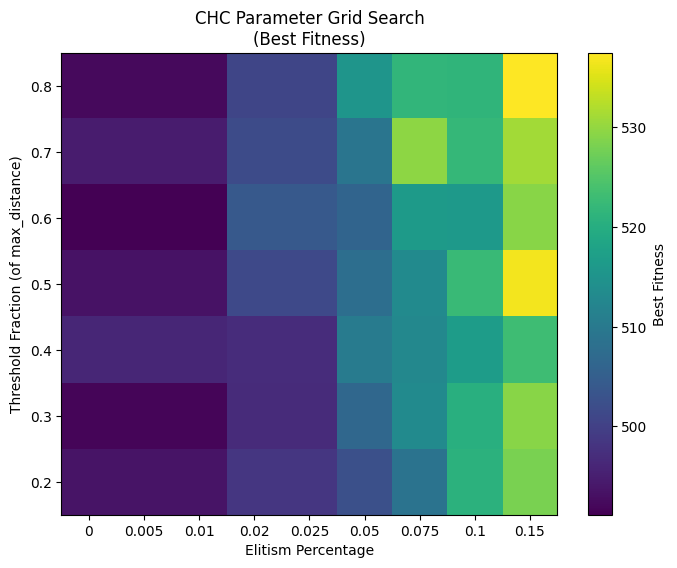

In [8]:
import matplotlib.pyplot as plt

# Fixed settings for the grid search.
fixed_pop_size = 100
fixed_max_resets = 50

# Compute max_distance from current dimension.
dim = NUM_ROOMS * TIME_SLOTS
max_distance = (MAX_TEMP - MIN_TEMP) * np.sqrt(dim)

# Define grid values:
threshold_fractions = [0.8,0.7,0.6, 0.5, 0.4,0.3,0.2]  # The initial_threshold will be these fractions * max_distance.
elitism_percentages = [0,0.005,0.01,0.02,0.025,0.05,0.075, 0.1, 0.15]

# Prepare a 2D grid to store fitness values.
fitness_grid = np.zeros((len(threshold_fractions), len(elitism_percentages)))

for i, frac in enumerate(threshold_fractions):
    for j, elit in enumerate(elitism_percentages):
        random.seed(GLOBAL_SEED)
        np.random.seed(GLOBAL_SEED)
        init_thresh = frac * max_distance
        best_sol, best_fit = chc_algorithm(
            population_size=fixed_pop_size,
            max_resets=fixed_max_resets,
            initial_threshold=init_thresh,
            elitism_percentage=elit,
            verbose=False
        )
        fitness_grid[i, j] = best_fit

# Find best parameters.
min_index = np.unravel_index(np.argmin(fitness_grid), fitness_grid.shape)
best_threshold_fraction = threshold_fractions[min_index[0]]
best_elitism_percentage = elitism_percentages[min_index[1]]
best_overall_fitness = fitness_grid[min_index]

print("Best Overall Parameters:")
print(f"  Threshold Fraction: {best_threshold_fraction}")
print(f"  Elitism Percentage: {best_elitism_percentage}")
print(f"  Achieved Fitness: {best_overall_fitness}")

# Plot heatmap: x-axis = elitism percentage, y-axis = initial_threshold fraction.
plt.figure(figsize=(8,6))
plt.imshow(fitness_grid, cmap='viridis', aspect='auto')
plt.colorbar(label="Best Fitness")
plt.xticks(ticks=np.arange(len(elitism_percentages)), labels=elitism_percentages)
plt.yticks(ticks=np.arange(len(threshold_fractions)), labels=threshold_fractions)
plt.xlabel("Elitism Percentage")
plt.ylabel("Threshold Fraction (of max_distance)")
plt.title("CHC Parameter Grid Search\n(Best Fitness)")
plt.show()


In [4]:
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

best_sol, best_fit = chc_algorithm(
    verbose=True
)
print("\nCHC Algorithm Best Fitness:", best_fit)

CHC Resets: 100%|██████████| 50/50 [01:45<00:00,  2.10s/it]


CHC Algorithm Best Fitness: 471.56174237858914


# Multimodal with clearing

In [11]:
import random
import numpy as np
from tqdm import tqdm

def ga_with_clearing(population_size=250,
                     num_clearings=250,
                     clearing_radius=0.9,
                     niche_capacity=1,
                     verbose=False):
    """
    Genetic Algorithm with Clearing for Multimodal Optimization.
    
    This function implements a genetic algorithm that incorporates a clearing mechanism
    to promote diversity and to help locate multiple optima in the search space.
    
    The only adjustable parameters are:
      - population_size: Number of individuals in the population.
      - num_clearings: Number of clearing iterations (i.e. generations).
      - clearing_radius: The distance threshold within which individuals are considered to be in the same niche.
      - niche_capacity: Maximum number of individuals allowed per niche without penalty.
      
    The algorithm uses fixed operators:
      - **Selection:** Tournament selection with a tournament size of 3.
      - **Crossover:** Uniform crossover.
      - **Mutation:** Gaussian mutation with a mutation rate of 0.1 and sigma of 0.1.
      - **Replacement:** Generational replacement (the entire population is replaced each iteration).
      
    The clearing mechanism penalizes individuals that are too similar (within the clearing radius) to a niche winner
    once the niche_capacity is exceeded (their fitness is set to np.inf).
    
    Parameters:
        population_size (int): Number of individuals in the population.
        num_clearings (int): Number of clearing iterations (generations) to run.
        clearing_radius (float): The radius within which individuals are considered part of the same niche.
        niche_capacity (int): Maximum number of individuals allowed per niche without penalty.
        verbose (bool): If True, displays a progress bar.
        
    Returns:
        tuple: (best_solution (list), best_fitness (float))
    
    Note: This function assumes that the helper functions `generate_random_solution()` and `fitness()`,
    as well as the global variables `MIN_TEMP`, `MAX_TEMP`, and `GLOBAL_SEED`, are defined elsewhere.
    """
    
    # --- Nested Helper Functions ---
    
    def tournament_selection(population, selection_fitness):
        """Select one individual using tournament selection (tournament size = 3)."""
        tournament_size = 3
        indices = random.sample(range(len(population)), tournament_size)
        best_index = indices[0]
        for idx in indices:
            if selection_fitness[idx] < selection_fitness[best_index]:
                best_index = idx
        return population[best_index].copy()
    
    def uniform_crossover(parent1, parent2):
        """Perform uniform crossover on two parents."""
        dim = len(parent1)
        mask = np.random.rand(dim) < 0.5
        child1 = np.where(mask, parent1, parent2)
        child2 = np.where(mask, parent2, parent1)
        return child1, child2
    
    def gaussian_mutation(individual):
        """
        Apply Gaussian mutation to an individual.
        
        Each gene is mutated with a probability of 0.1 by adding Gaussian noise with sigma 0.1.
        """
        mutation_rate = 0.1
        sigma = 0.1
        mutant = individual.copy()
        for i in range(len(mutant)):
            if random.random() < mutation_rate:
                mutant[i] += np.random.normal(0, sigma)
        return mutant
    
    def apply_clearing(population, fitnesses, clearing_radius, niche_capacity):
        """
        Apply the clearing mechanism to the population.
        
        Individuals are first sorted by fitness (lowest first). For each niche (group of similar individuals),
        only up to `niche_capacity` individuals are allowed to keep their fitness; the rest are penalized by setting
        their fitness to np.inf.
        """
        cleared_fitness = fitnesses.copy()
        sorted_indices = np.argsort(fitnesses)
        for i in range(len(sorted_indices)):
            idx_i = sorted_indices[i]
            if cleared_fitness[idx_i] == np.inf:
                continue
            niche_count = 1  # The best in the niche is the winner.
            for j in range(i+1, len(sorted_indices)):
                idx_j = sorted_indices[j]
                if cleared_fitness[idx_j] == np.inf:
                    continue
                distance = np.linalg.norm(population[idx_i] - population[idx_j])
                if distance < clearing_radius:
                    if niche_count < niche_capacity:
                        niche_count += 1
                    else:
                        cleared_fitness[idx_j] = np.inf
        return cleared_fitness

    # --- End of Helper Functions ---
    
    # Generate the initial population.
    pop = [np.array(generate_random_solution()) for _ in range(population_size)]
    fitnesses = [fitness(ind) for ind in pop]
    best_index = np.argmin(fitnesses)
    best_solution = pop[best_index].copy()
    best_fitness = fitnesses[best_index]
    
    # Determine the problem's dimensionality.
    dim = len(pop[0])
    
    # Progress bar for visualization.
    pbar = tqdm(total=num_clearings, desc="GA with Clearing", disable=not verbose)
    
    for clr in range(num_clearings):
        # 1. Apply clearing mechanism to penalize similar individuals.
        cleared_fitness = apply_clearing(pop, fitnesses, clearing_radius, niche_capacity)
        
        new_population = []
        while len(new_population) < population_size:
            # 2. Selection using tournament selection.
            parent1 = tournament_selection(pop, cleared_fitness)
            parent2 = tournament_selection(pop, cleared_fitness)
            
            # 3. Crossover (uniform).
            child1, child2 = uniform_crossover(parent1, parent2)
            
            # 4. Mutation (Gaussian).
            child1 = gaussian_mutation(child1)
            child2 = gaussian_mutation(child2)
            
            # Clip offspring to problem bounds.
            child1 = np.clip(child1, MIN_TEMP, MAX_TEMP)
            child2 = np.clip(child2, MIN_TEMP, MAX_TEMP)
            
            new_population.append(child1)
            if len(new_population) < population_size:
                new_population.append(child2)
        
        # 5. Replace the entire population with the new offspring.
        pop = new_population
        fitnesses = [fitness(ind) for ind in pop]
        
        # Update the best solution found so far.
        current_best_index = np.argmin(fitnesses)
        if fitnesses[current_best_index] < best_fitness:
            best_fitness = fitnesses[current_best_index]
            best_solution = pop[current_best_index].copy()
        
        pbar.update(1)
    
    pbar.close()
    return best_solution.tolist(), best_fitness

# -----------------------------------------------------------------------------
# Set random seeds for reproducibility.
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

# Example usage:
best_sol, best_fit = ga_with_clearing(
    population_size=50,
    num_clearings=50,       
    clearing_radius=0.5,   
    niche_capacity=1,
    verbose=True          
)
print("\nGA with Clearing Best Fitness:", best_fit)


GA with Clearing: 100%|██████████| 50/50 [00:00<00:00, 209.18it/s]


GA with Clearing Best Fitness: 3070.6343576118534


Population Size Study: 100%|██████████| 7/7 [01:00<00:00,  8.65s/it]


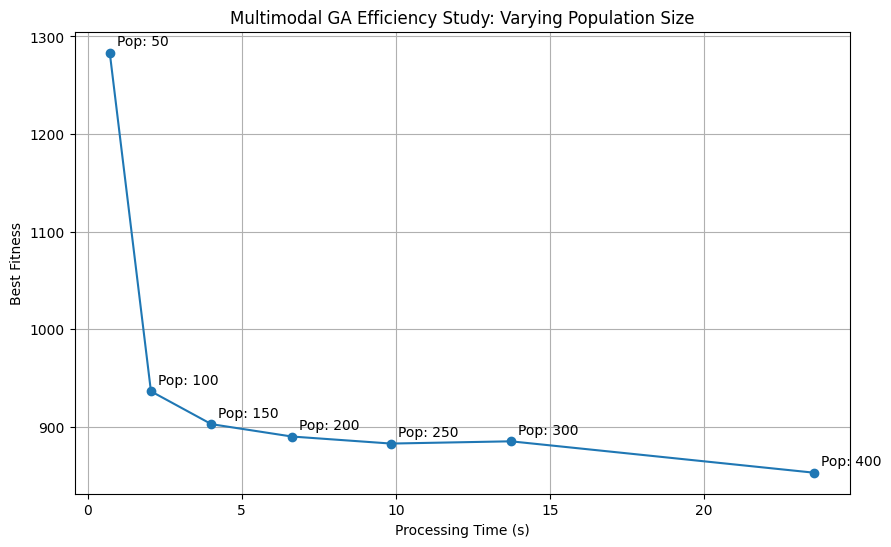

Num Clearings Study: 100%|██████████| 6/6 [01:09<00:00, 11.51s/it]


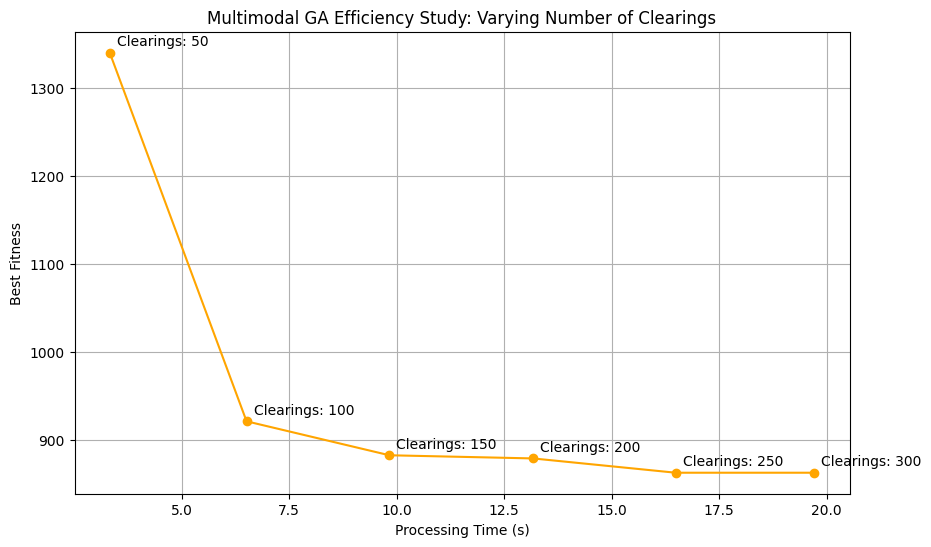

In [6]:
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import random
import numpy as np

# Efficiency Study 1: Vary Population Size (with a fixed number of clearing iterations)
pop_sizes = [50, 100, 150, 200, 250, 300, 400]
fixed_num_clearings = 150  # Fixed number of clearing iterations (generations) for this study

fitness_vs_pop = []
times_vs_pop = []

for pop in tqdm(pop_sizes, desc="Population Size Study"):
    # Reset the random seeds for reproducibility.
    random.seed(GLOBAL_SEED)
    np.random.seed(GLOBAL_SEED)
    start = time.time()
    best_sol, best_fit = ga_with_clearing(
        population_size=pop,
        num_clearings=fixed_num_clearings,
        clearing_radius=0.5,    # Adjust based on your problem's scale
        niche_capacity=1,
        verbose=False
    )
    elapsed = time.time() - start
    fitness_vs_pop.append(best_fit)
    times_vs_pop.append(elapsed)

# Plot: x = processing time, y = best fitness; annotate with population size.
plt.figure(figsize=(10, 6))
plt.plot(times_vs_pop, fitness_vs_pop, marker='o', linestyle='-')
for i, pop in enumerate(pop_sizes):
    plt.annotate(f"Pop: {pop}", (times_vs_pop[i], fitness_vs_pop[i]), textcoords="offset points", xytext=(5, 5))
plt.xlabel("Processing Time (s)")
plt.ylabel("Best Fitness")
plt.title("Multimodal GA Efficiency Study: Varying Population Size")
plt.grid(True)
plt.show()

# Efficiency Study 2: Vary Number of Clearing Iterations (with a fixed population size)
num_clearings_list = [50, 100, 150, 200, 250, 300]
fixed_pop_size = 250  # Fixed population size for this study

fitness_vs_clearings = []
times_vs_clearings = []

for clears in tqdm(num_clearings_list, desc="Num Clearings Study"):
    # Reset seeds for reproducibility.
    random.seed(GLOBAL_SEED)
    np.random.seed(GLOBAL_SEED)
    start = time.time()
    best_sol, best_fit = ga_with_clearing(
        population_size=fixed_pop_size,
        num_clearings=clears,
        clearing_radius=0.5,
        niche_capacity=1,
        verbose=False
    )
    elapsed = time.time() - start
    fitness_vs_clearings.append(best_fit)
    times_vs_clearings.append(elapsed)

# Plot: x = processing time, y = best fitness; annotate with number of clearings.
plt.figure(figsize=(10, 6))
plt.plot(times_vs_clearings, fitness_vs_clearings, marker='o', linestyle='-', color='orange')
for i, clears in enumerate(num_clearings_list):
    plt.annotate(f"Clearings: {clears}", (times_vs_clearings[i], fitness_vs_clearings[i]), textcoords="offset points", xytext=(5, 5))
plt.xlabel("Processing Time (s)")
plt.ylabel("Best Fitness")
plt.title("Multimodal GA Efficiency Study: Varying Number of Clearings")
plt.grid(True)
plt.show()


Parameter Grid Search: 100%|██████████| 28/28 [02:03<00:00,  4.41s/it]

Best Overall Parameters:
  Clearing Radius: 0.9
  Niche Capacity: 0
  Achieved Fitness: 918.3542241898904


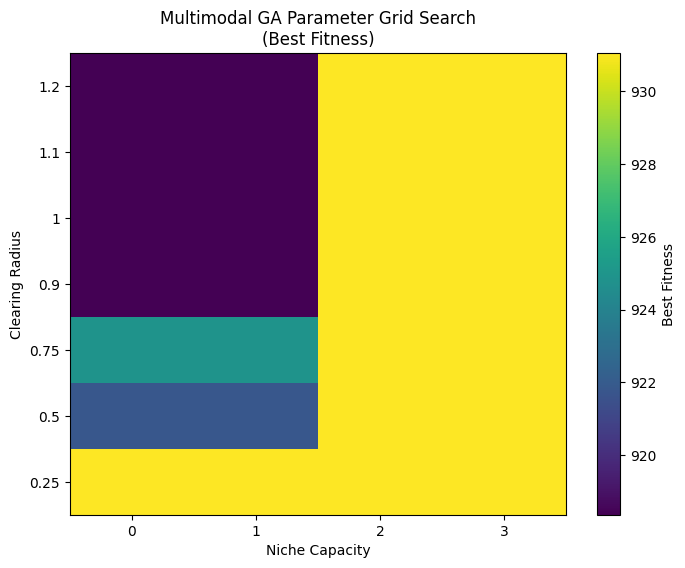

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

# Fixed settings for the grid search.
fixed_pop_size = 200
fixed_num_clearings = 100  # Fixed number of clearing iterations (generations)

# Define grid values for the two key parameters:
clearing_radii = [0.25, 0.5, 0.75,0.9, 1, 1.1,1.2]  # Different values for the clearing radius.
niche_capacities = [0, 1, 2, 3]             # Different values for niche capacity.

# Prepare a 2D grid (rows: clearing radius, columns: niche capacity) to store fitness values.
fitness_grid = np.zeros((len(clearing_radii), len(niche_capacities)))

# Total number of parameter combinations.
total_combinations = len(clearing_radii) * len(niche_capacities)
pbar = tqdm(total=total_combinations, desc="Parameter Grid Search")

# Iterate over the grid of parameter combinations.
for i, cr in enumerate(clearing_radii):
    for j, nc in enumerate(niche_capacities):
        # Reset random seeds for reproducibility.
        random.seed(GLOBAL_SEED)
        np.random.seed(GLOBAL_SEED)
        
        # Run the multimodal GA with the current clearing parameters.
        best_sol, best_fit = ga_with_clearing(
            population_size=fixed_pop_size,
            num_clearings=fixed_num_clearings,
            clearing_radius=cr,
            niche_capacity=nc,
            verbose=False
        )
        
        # Store the best fitness achieved for this combination.
        fitness_grid[i, j] = best_fit
        
        pbar.update(1)
pbar.close()

# Identify the best parameters based on the lowest fitness value.
min_index = np.unravel_index(np.argmin(fitness_grid), fitness_grid.shape)
best_clearing_radius = clearing_radii[min_index[0]]
best_niche_capacity = niche_capacities[min_index[1]]
best_overall_fitness = fitness_grid[min_index]

print("Best Overall Parameters:")
print(f"  Clearing Radius: {best_clearing_radius}")
print(f"  Niche Capacity: {best_niche_capacity}")
print(f"  Achieved Fitness: {best_overall_fitness}")

# Plot a heatmap of the grid search results.
plt.figure(figsize=(8, 6))
# Use origin='lower' so that the smallest clearing radius appears at the bottom.
plt.imshow(fitness_grid, cmap='viridis', aspect='auto', origin='lower')
plt.colorbar(label="Best Fitness")
plt.xticks(ticks=np.arange(len(niche_capacities)), labels=niche_capacities)
plt.yticks(ticks=np.arange(len(clearing_radii)), labels=clearing_radii)
plt.xlabel("Niche Capacity")
plt.ylabel("Clearing Radius")
plt.title("Multimodal GA Parameter Grid Search\n(Best Fitness)")
plt.show()


In [12]:
best_sol, best_fit = ga_with_clearing(
    verbose=True          
)
print("\nGA with Clearing Best Fitness:", best_fit)

GA with Clearing: 100%|██████████| 250/250 [00:16<00:00, 15.11it/s]


GA with Clearing Best Fitness: 858.2440221209027


# Differential Evolution

In [24]:
import random
import numpy as np
from tqdm import tqdm

def differential_evolution(
        population_size=25,
        num_generations=7000,
        F=0.3,
        CR=0.3,
        verbose=False):
    """
    Differential Evolution (DE) Algorithm.
    
    ---------------------------
    This function implements a Differential Evolution algorithm with the following configuration:
    
      - **Mutation Strategy:** DE/rand/1, where for each target vector,
            donor = x_r1 + F * (x_r2 - x_r3),
        using three randomly selected, distinct vectors.
      
      - **Crossover:** Binomial (uniform) crossover. Each gene in the trial vector is inherited
        from the donor with probability CR, or from the target otherwise.
      
      - **Selection:** Greedy selection where the trial vector replaces the target vector
        if it has a lower (better) fitness.
      
    High-Level Workflow:
      1. **Initialization:**  
         Generate an initial population of candidate solutions randomly using `generate_random_solution()`.
      
      2. **Mutation:**  
         For each target vector, generate a donor vector using the DE/rand/1 strategy.
      
      3. **Crossover:**  
         Create a trial vector by mixing the donor with the target vector according to the crossover rate CR.
      
      4. **Selection:**  
         Evaluate the trial vector using `fitness()`. If it is better than the target vector, it replaces the target.
      
      5. **Iteration:**  
         Repeat the mutation, crossover, and selection steps for a fixed number of generations.
      
      6. **Return:**  
         The best solution found and its corresponding fitness value.
    
    Parameters:
        population_size (int): Number of individuals in the population.
        num_generations (int): Number of generations (iterations) to run the algorithm.
        F (float): Scaling factor for the mutation step (typically between 0.4 and 1.0).
        CR (float): Crossover rate (probability for binomial crossover, typically between 0.1 and 0.9).
        verbose (bool): If True, displays a tqdm progress bar.
    
    Returns:
        tuple: (best_solution (list), best_fitness (float))
    
    Note:
        This function assumes that helper functions `generate_random_solution()` and `fitness()` are defined,
        as well as global variables `MIN_TEMP`, `MAX_TEMP`, and optionally `GLOBAL_SEED`.
    """
    
    # --- Nested Helper Functions ---
    
    def mutate(target_idx):
        """
        Mutation using DE/rand/1 strategy.
        
        For the target individual at index target_idx, randomly select three distinct indices
        (different from target_idx) from the population, and create a donor vector.
        """
        indices = list(range(population_size))
        indices.remove(target_idx)
        r1, r2, r3 = random.sample(indices, 3)
        donor = population[r1] + F * (population[r2] - population[r3])
        # Ensure donor is within bounds.
        donor = np.clip(donor, MIN_TEMP, MAX_TEMP)
        return donor
    
    def crossover(target, donor):
        """
        Binomial (uniform) crossover.
        
        Creates a trial vector by choosing, for each gene, the donor gene with probability CR,
        and the target gene otherwise. A randomly selected gene is always inherited from the donor
        to guarantee that the trial vector differs from the target.
        """
        dim = len(target)
        trial = np.empty(dim)
        jrand = random.randint(0, dim - 1)
        for j in range(dim):
            if random.random() < CR or j == jrand:
                trial[j] = donor[j]
            else:
                trial[j] = target[j]
        return trial
    
    # --- End of Helper Functions ---
    
    # Initialize the population.
    population = [np.array(generate_random_solution()) for _ in range(population_size)]
    fitnesses = [fitness(ind) for ind in population]
    best_idx = np.argmin(fitnesses)
    best_solution = population[best_idx].copy()
    best_fitness = fitnesses[best_idx]
    
    # Set up progress monitoring.
    pbar = tqdm(total=num_generations, desc="Differential Evolution", disable=not verbose)
    
    for gen in range(num_generations):
        new_population = []
        new_fitnesses = []
        for i in range(population_size):
            target = population[i]
            donor = mutate(i)
            trial = crossover(target, donor)
            trial_fitness = fitness(trial)
            # Greedy selection: if trial is better, use it; otherwise, retain the target.
            if trial_fitness < fitnesses[i]:
                new_population.append(trial)
                new_fitnesses.append(trial_fitness)
                if trial_fitness < best_fitness:
                    best_fitness = trial_fitness
                    best_solution = trial.copy()
            else:
                new_population.append(target)
                new_fitnesses.append(fitnesses[i])
        population = new_population
        fitnesses = new_fitnesses
        pbar.update(1)
    
    pbar.close()
    return best_solution.tolist(), best_fitness

# -----------------------------------------------------------------------------
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

best_sol, best_fit = differential_evolution(
    population_size=100,
    num_generations=500,
    F=0.8,
    CR=0.9,
    verbose=True
)
print("\nDifferential Evolution Best Fitness:", best_fit)


Differential Evolution: 100%|██████████| 500/500 [00:02<00:00, 187.62it/s]


Differential Evolution Best Fitness: 6453.548089462921


Population Size Study: 100%|██████████| 11/11 [02:25<00:00, 13.19s/it]


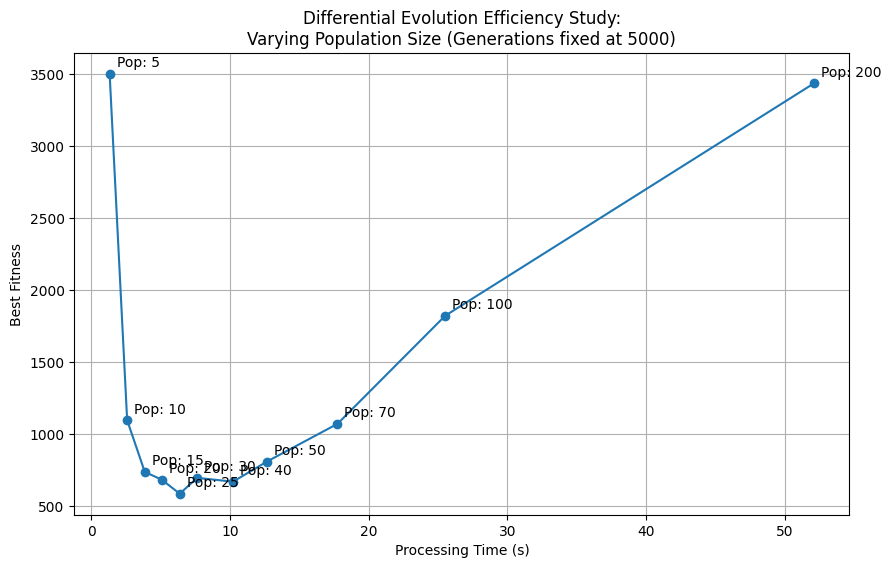

Generations Study: 100%|██████████| 6/6 [01:09<00:00, 11.56s/it]


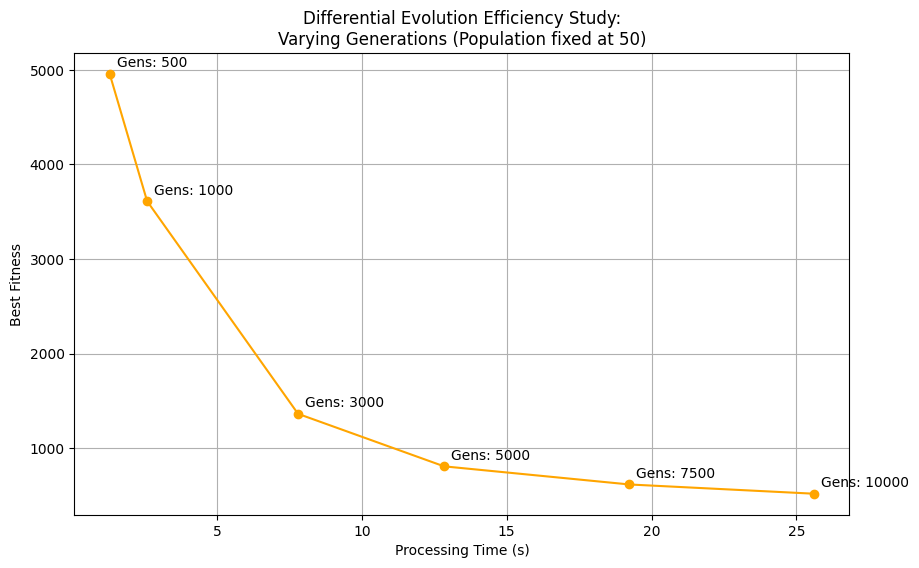

In [23]:
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import random
import numpy as np

# -------------------------------
# Efficiency Study 1: Vary Population Size
# -------------------------------
pop_sizes = [5,10,15,20,25,30,40,50, 70, 100, 200]
fixed_generations = 5000  # Fixed number of generations for this study

fitness_vs_pop = []
times_vs_pop = []

for pop in tqdm(pop_sizes, desc="Population Size Study"):
    # Reset the random seeds for reproducibility.
    random.seed(GLOBAL_SEED)
    np.random.seed(GLOBAL_SEED)
    
    start = time.time()
    best_sol, best_fit = differential_evolution(
        population_size=pop,
        num_generations=fixed_generations,
        F=0.8,
        CR=0.9,
        verbose=False
    )
    elapsed = time.time() - start
    fitness_vs_pop.append(best_fit)
    times_vs_pop.append(elapsed)

# Plot: x-axis = processing time, y-axis = best fitness; annotate with population size.
plt.figure(figsize=(10, 6))
plt.plot(times_vs_pop, fitness_vs_pop, marker='o', linestyle='-')
for i, pop in enumerate(pop_sizes):
    plt.annotate(f"Pop: {pop}", (times_vs_pop[i], fitness_vs_pop[i]), textcoords="offset points", xytext=(5, 5))
plt.xlabel("Processing Time (s)")
plt.ylabel("Best Fitness")
plt.title("Differential Evolution Efficiency Study:\nVarying Population Size (Generations fixed at {})".format(fixed_generations))
plt.grid(True)
plt.show()

# -------------------------------
# Efficiency Study 2: Vary Number of Generations
# -------------------------------
gen_list = [500, 1000,3000, 5000, 7500,10000]
fixed_pop_size = 50  # Fixed population size for this study

fitness_vs_gen = []
times_vs_gen = []

for gens in tqdm(gen_list, desc="Generations Study"):
    # Reset seeds for reproducibility.
    random.seed(GLOBAL_SEED)
    np.random.seed(GLOBAL_SEED)
    
    start = time.time()
    best_sol, best_fit = differential_evolution(
        population_size=fixed_pop_size,
        num_generations=gens,
        F=0.8,
        CR=0.9,
        verbose=False
    )
    elapsed = time.time() - start
    fitness_vs_gen.append(best_fit)
    times_vs_gen.append(elapsed)

# Plot: x-axis = processing time, y-axis = best fitness; annotate with generations.
plt.figure(figsize=(10, 6))
plt.plot(times_vs_gen, fitness_vs_gen, marker='o', linestyle='-', color='orange')
for i, gens in enumerate(gen_list):
    plt.annotate(f"Gens: {gens}", (times_vs_gen[i], fitness_vs_gen[i]), textcoords="offset points", xytext=(5, 5))
plt.xlabel("Processing Time (s)")
plt.ylabel("Best Fitness")
plt.title("Differential Evolution Efficiency Study:\nVarying Generations (Population fixed at {})".format(fixed_pop_size))
plt.grid(True)
plt.show()


DE Parameter Grid Search: 100%|██████████| 25/25 [01:38<00:00,  3.95s/it]

Best Overall Parameters:
  Scaling Factor (F): 0.3
  Crossover Rate (CR): 0.3
  Achieved Fitness: 462.8914106755898


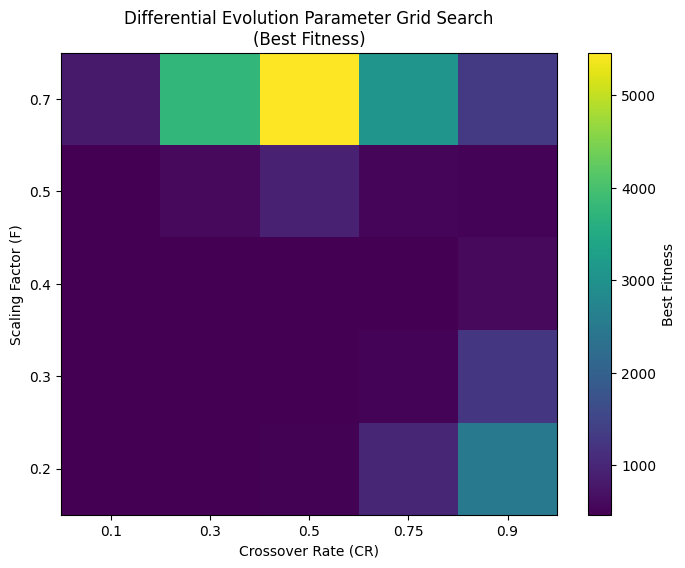

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

# Fixed settings for the grid search.
fixed_pop_size = 50
fixed_num_generations = 1500

# Define grid values for the Differential Evolution parameters.
F_values = [0.2, 0.3, 0.4,0.5, 0.7]       # Scaling factor values.
CR_values = [0.1, 0.3, 0.5, 0.75, 0.9]   # Crossover rate values.

# Prepare a 2D grid to store the best fitness values.
fitness_grid = np.zeros((len(F_values), len(CR_values)))

# Total number of parameter combinations for progress monitoring.
total_combinations = len(F_values) * len(CR_values)
pbar = tqdm(total=total_combinations, desc="DE Parameter Grid Search")

# Loop over each combination of F and CR.
for i, F_param in enumerate(F_values):
    for j, CR_param in enumerate(CR_values):
        # Reset random seeds for reproducibility.
        random.seed(GLOBAL_SEED)
        np.random.seed(GLOBAL_SEED)
        
        # Run Differential Evolution with the current parameter settings.
        best_sol, best_fit = differential_evolution(
            population_size=fixed_pop_size,
            num_generations=fixed_num_generations,
            F=F_param,
            CR=CR_param,
            verbose=False
        )
        
        # Record the best fitness achieved for this parameter combination.
        fitness_grid[i, j] = best_fit
        
        pbar.update(1)

pbar.close()

# Identify the best parameter combination based on the lowest fitness value.
min_index = np.unravel_index(np.argmin(fitness_grid), fitness_grid.shape)
best_F = F_values[min_index[0]]
best_CR = CR_values[min_index[1]]
best_overall_fitness = fitness_grid[min_index]

print("Best Overall Parameters:")
print(f"  Scaling Factor (F): {best_F}")
print(f"  Crossover Rate (CR): {best_CR}")
print(f"  Achieved Fitness: {best_overall_fitness}")

# Plot a heatmap: x-axis = Crossover Rate (CR), y-axis = Scaling Factor (F)
plt.figure(figsize=(8, 6))
plt.imshow(fitness_grid, cmap='viridis', aspect='auto', origin='lower')
plt.colorbar(label="Best Fitness")
plt.xticks(ticks=np.arange(len(CR_values)), labels=CR_values)
plt.yticks(ticks=np.arange(len(F_values)), labels=F_values)
plt.xlabel("Crossover Rate (CR)")
plt.ylabel("Scaling Factor (F)")
plt.title("Differential Evolution Parameter Grid Search\n(Best Fitness)")
plt.show()


In [25]:
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

best_sol, best_fit = differential_evolution(
    verbose=True
)
print("\nDifferential Evolution Best Fitness:", best_fit)

Differential Evolution: 100%|██████████| 7000/7000 [00:09<00:00, 737.90it/s]


Differential Evolution Best Fitness: 495.5446723255185


# Evolution Strategies

In [34]:
import random
import numpy as np
from tqdm import tqdm

def evolution_strategies(
        population_size=100,
        num_generations=200,
        sigma=0.075,
        offspring_multiplier=9,
        verbose=False):
    """
    Evolution Strategies (ES) Algorithm using a (mu, lambda)-ES approach.
    
    ---------------------------
    This function implements a basic Evolution Strategies algorithm:
    
      - **Initialization:**  
        A parent population of size mu (given by population_size) is generated using
        `generate_random_solution()`.
      
      - **Offspring Generation (Mutation):**  
        For each parent, lambda offspring (lambda = offspring_multiplier * population_size)
        are produced by adding Gaussian noise with standard deviation `sigma` to the parent's vector.
        The resulting offspring are clipped to the problem bounds defined by [MIN_TEMP, MAX_TEMP].
      
      - **Selection:**  
        All offspring are evaluated using `fitness()`, and the best mu individuals are selected
        to form the next generation's parent population.
      
      - **Iteration:**  
        The mutation and selection steps are repeated for a fixed number of generations.
      
      - **Return:**  
        The best solution found and its corresponding fitness value.
    
    Parameters:
        population_size (int): Number of individuals in the parent population (mu).
        num_generations (int): Number of generations (iterations) to run the algorithm.
        sigma (float): Standard deviation used for Gaussian mutation.
        offspring_multiplier (int): Multiplier to determine the number of offspring per generation 
                                    (lambda = offspring_multiplier * population_size).
        verbose (bool): If True, displays a tqdm progress bar.
    
    Returns:
        tuple: (best_solution (list), best_fitness (float))
    
    Note:
        This function assumes that helper functions `generate_random_solution()` and `fitness()` are defined,
        as well as global constants `MIN_TEMP`, `MAX_TEMP`, and optionally `GLOBAL_SEED` for reproducibility.
    """
    
    # --- Nested Helper Function ---
    def mutate(individual):
        """
        Applies Gaussian mutation to an individual.
        
        Each gene is perturbed by adding Gaussian noise with standard deviation `sigma`.
        The mutated individual is then clipped to the bounds [MIN_TEMP, MAX_TEMP].
        """
        mutant = individual + np.random.normal(0, sigma, size=len(individual))
        mutant = np.clip(mutant, MIN_TEMP, MAX_TEMP)
        return mutant
    
    # --- End of Helper Function ---
    
    # Initialize the parent population.
    population = [np.array(generate_random_solution()) for _ in range(population_size)]
    fitnesses = [fitness(ind) for ind in population]
    
    best_idx = np.argmin(fitnesses)
    best_solution = population[best_idx].copy()
    best_fitness = fitnesses[best_idx]
    
    # Total number of offspring produced per generation.
    total_offspring = offspring_multiplier * population_size
    
    # Set up the progress bar.
    pbar = tqdm(total=num_generations, desc="Evolution Strategies", disable=not verbose)
    
    for gen in range(num_generations):
        offspring = []
        # Generate offspring for each parent.
        for parent in population:
            for _ in range(offspring_multiplier):
                child = mutate(parent)
                offspring.append(child)
        
        # Evaluate all offspring.
        offspring_fitnesses = [fitness(child) for child in offspring]
        
        # Select the best 'population_size' offspring (using (mu, lambda)-selection).
        indices_sorted = np.argsort(offspring_fitnesses)
        new_population = [offspring[i] for i in indices_sorted[:population_size]]
        new_fitnesses = [offspring_fitnesses[i] for i in indices_sorted[:population_size]]
        
        population = new_population
        fitnesses = new_fitnesses
        
        # Update the best solution found so far.
        current_best_idx = np.argmin(fitnesses)
        if fitnesses[current_best_idx] < best_fitness:
            best_fitness = fitnesses[current_best_idx]
            best_solution = population[current_best_idx].copy()
        
        pbar.update(1)
    
    pbar.close()
    return best_solution.tolist(), best_fitness

# -----------------------------------------------------------------------------
# Example usage:
# Set random seeds for reproducibility.
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

best_sol, best_fit = evolution_strategies(
    population_size=50,
    num_generations=100,
    sigma=0.1,
    offspring_multiplier=7,
    verbose=True
)
print("\nEvolution Strategies Best Fitness:", best_fit)


Evolution Strategies: 100%|██████████| 100/100 [00:01<00:00, 92.98it/s]


Evolution Strategies Best Fitness: 3087.579394682878


Population Size Study (ES): 100%|██████████| 6/6 [00:29<00:00,  4.85s/it]


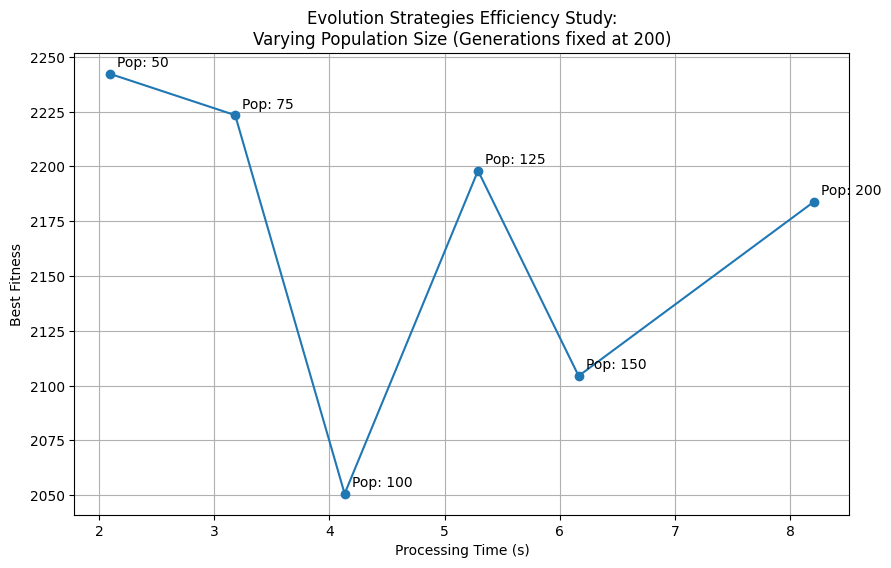

Generations Study (ES): 100%|██████████| 6/6 [00:21<00:00,  3.66s/it]


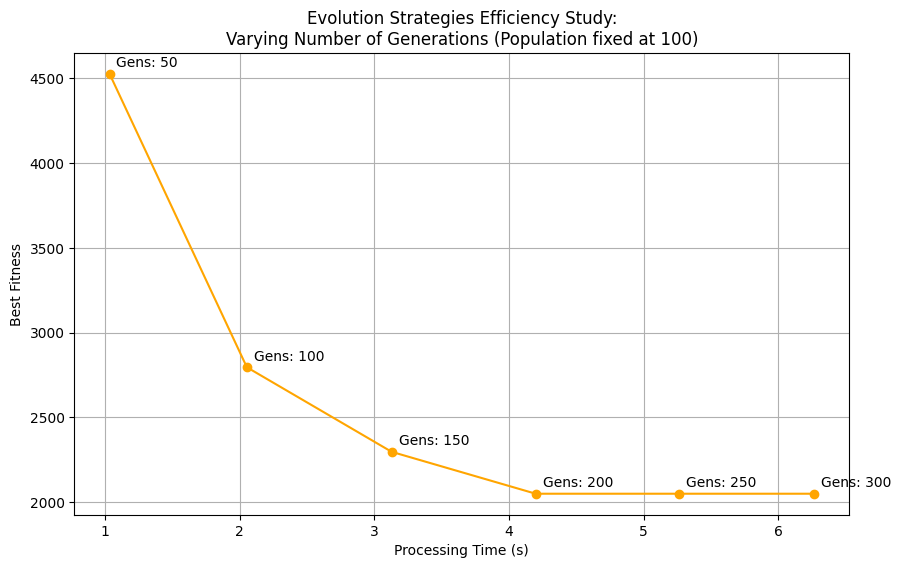

In [30]:
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import random
import numpy as np

# -------------------------------
# Efficiency Study 1: Vary Population Size for Evolution Strategies
# -------------------------------

# Define a range of parent population sizes.
pop_sizes = [50,75,100,125,150,200]
fixed_num_generations = 200  # Fixed number of generations for this study.
sigma = 0.1                 # Standard deviation for Gaussian mutation.
offspring_multiplier = 7    # Offspring multiplier (lambda = multiplier * population_size).

fitness_vs_pop = []
times_vs_pop = []

for pop in tqdm(pop_sizes, desc="Population Size Study (ES)"):
    # Reset the random seeds for reproducibility.
    random.seed(GLOBAL_SEED)
    np.random.seed(GLOBAL_SEED)
    
    start = time.time()
    best_sol, best_fit = evolution_strategies(
        population_size=pop,
        num_generations=fixed_num_generations,
        sigma=sigma,
        offspring_multiplier=offspring_multiplier,
        verbose=False
    )
    elapsed = time.time() - start
    fitness_vs_pop.append(best_fit)
    times_vs_pop.append(elapsed)

# Plot: x-axis = processing time, y-axis = best fitness; annotate with population size.
plt.figure(figsize=(10, 6))
plt.plot(times_vs_pop, fitness_vs_pop, marker='o', linestyle='-')
for i, pop in enumerate(pop_sizes):
    plt.annotate(f"Pop: {pop}", (times_vs_pop[i], fitness_vs_pop[i]), textcoords="offset points", xytext=(5, 5))
plt.xlabel("Processing Time (s)")
plt.ylabel("Best Fitness")
plt.title(f"Evolution Strategies Efficiency Study:\nVarying Population Size (Generations fixed at {fixed_num_generations})")
plt.grid(True)
plt.show()

# -------------------------------
# Efficiency Study 2: Vary Number of Generations for Evolution Strategies
# -------------------------------

# Define a range of generation counts.
gen_list = [50, 100, 150, 200, 250, 300]
fixed_pop_size = 100  # Fixed population size for this study.

fitness_vs_gen = []
times_vs_gen = []

for gens in tqdm(gen_list, desc="Generations Study (ES)"):
    # Reset the random seeds for reproducibility.
    random.seed(GLOBAL_SEED)
    np.random.seed(GLOBAL_SEED)
    
    start = time.time()
    best_sol, best_fit = evolution_strategies(
        population_size=fixed_pop_size,
        num_generations=gens,
        sigma=sigma,
        offspring_multiplier=offspring_multiplier,
        verbose=False
    )
    elapsed = time.time() - start
    fitness_vs_gen.append(best_fit)
    times_vs_gen.append(elapsed)

# Plot: x-axis = processing time, y-axis = best fitness; annotate with generation count.
plt.figure(figsize=(10, 6))
plt.plot(times_vs_gen, fitness_vs_gen, marker='o', linestyle='-', color='orange')
for i, gens in enumerate(gen_list):
    plt.annotate(f"Gens: {gens}", (times_vs_gen[i], fitness_vs_gen[i]), textcoords="offset points", xytext=(5, 5))
plt.xlabel("Processing Time (s)")
plt.ylabel("Best Fitness")
plt.title(f"Evolution Strategies Efficiency Study:\nVarying Number of Generations (Population fixed at {fixed_pop_size})")
plt.grid(True)
plt.show()


ES Parameter Grid Search: 100%|██████████| 25/25 [01:56<00:00,  4.64s/it]

Best Overall Parameters for Evolution Strategies:
  Sigma (mutation std): 0.075
  Offspring Multiplier: 9
  Achieved Fitness: 1724.3447847743018


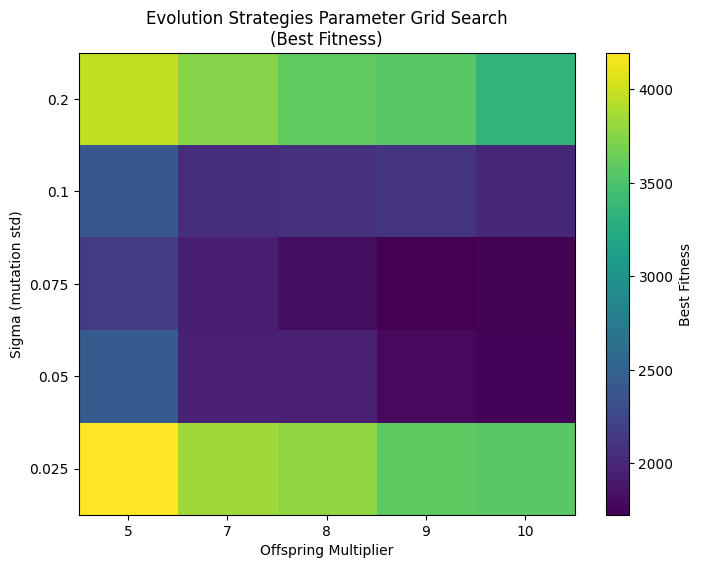

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

# Fixed settings for the grid search.
fixed_pop_size = 100
fixed_num_generations = 200

# Define grid values for Evolution Strategies parameters.
sigma_values = [0.025,0.05,0.075, 0.1, 0.2]                # Mutation standard deviation.
offspring_multipliers = [5, 7,8, 9,10]                       # Offspring multiplier (lambda = multiplier * population_size).

# Prepare a 2D grid to store the best fitness values.
fitness_grid = np.zeros((len(sigma_values), len(offspring_multipliers)))

# Total number of parameter combinations for progress monitoring.
total_combinations = len(sigma_values) * len(offspring_multipliers)
pbar = tqdm(total=total_combinations, desc="ES Parameter Grid Search")

# Loop over each combination of sigma and offspring_multiplier.
for i, sigma_val in enumerate(sigma_values):
    for j, off_mult in enumerate(offspring_multipliers):
        # Reset the random seeds for reproducibility.
        random.seed(GLOBAL_SEED)
        np.random.seed(GLOBAL_SEED)
        
        # Run the Evolution Strategies algorithm with the current parameter settings.
        best_sol, best_fit = evolution_strategies(
            population_size=fixed_pop_size,
            num_generations=fixed_num_generations,
            sigma=sigma_val,
            offspring_multiplier=off_mult,
            verbose=False
        )
        
        # Record the best fitness achieved for this parameter combination.
        fitness_grid[i, j] = best_fit
        
        pbar.update(1)

pbar.close()

# Identify the best parameter combination based on the lowest fitness value.
min_index = np.unravel_index(np.argmin(fitness_grid), fitness_grid.shape)
best_sigma = sigma_values[min_index[0]]
best_offspring_multiplier = offspring_multipliers[min_index[1]]
best_overall_fitness = fitness_grid[min_index]

print("Best Overall Parameters for Evolution Strategies:")
print(f"  Sigma (mutation std): {best_sigma}")
print(f"  Offspring Multiplier: {best_offspring_multiplier}")
print(f"  Achieved Fitness: {best_overall_fitness}")

# Plot a heatmap: x-axis = Offspring Multiplier, y-axis = Sigma.
plt.figure(figsize=(8, 6))
plt.imshow(fitness_grid, cmap='viridis', aspect='auto', origin='lower')
plt.colorbar(label="Best Fitness")
plt.xticks(ticks=np.arange(len(offspring_multipliers)), labels=offspring_multipliers)
plt.yticks(ticks=np.arange(len(sigma_values)), labels=sigma_values)
plt.xlabel("Offspring Multiplier")
plt.ylabel("Sigma (mutation std)")
plt.title("Evolution Strategies Parameter Grid Search\n(Best Fitness)")
plt.show()


In [35]:
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

best_sol, best_fit = evolution_strategies(
    verbose=True
)
print("\nEvolution Strategies Best Fitness:", best_fit)

Evolution Strategies: 100%|██████████| 200/200 [00:05<00:00, 36.80it/s]


Evolution Strategies Best Fitness: 1724.3447847743018


In [ ]:
# Memetic Algorithms

In [ ]:
# Estimation of Distribution Algorithms

In [ ]:
# multi-population (or island model)